<a href="https://colab.research.google.com/github/antoniyaaboyanova/Human-Connectome-Project_Heritability/blob/main/Copy_of_Connectome_heritability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This code is adapted from NeuroMatch course dataset loader for data that was pulled from the Human Connectome Project 2020 and eventually preprocessed by NMA
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from scipy import stats
import sklearn
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from google.colab import files

In [ ]:
# Necessary for visualization
!pip install nilearn --quiet
from nilearn import plotting, datasets

     |████████████████████████████████| 4.9 MB 2.9 MB/s 


/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [ ]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

In [ ]:
fname = "hcp_rest.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/bqp7m/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [ ]:
fname = "hcp_covariates.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/x5p4g/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [ ]:
fname = f"{HCP_DIR}/atlas.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/j5kuc/download

In [ ]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    myelin=regions[2].astype(np.float),
)


In [ ]:
#This provides the parcellation on the fsaverage5 surface and approximates the MNI coordinates of each region for ease of visualization
with np.load(f"{HCP_DIR}/atlas.npz") as dobj:
  atlas = dict(**dobj)

In [ ]:
#Helper functions for data loading
def get_image_ids(name):
  """Get the 1-based image indices for runs in a given experiment.

    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files

  """
  run_ids = [
    i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code
  ]
  if not run_ids:
    raise ValueError(f"Found no data for '{name}''")
  return run_ids

def load_timeseries(subject, name, runs=None, concat=True, remove_mean=True):
  """Load timeseries data for a single subject.
  
  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment 
  offset = get_image_ids(name)[0]

  # Load each run's data
  bold_data = [
      load_single_timeseries(subject, offset + run, remove_mean) for run in runs
  ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(subject, bold_run, remove_mean=True):
  """Load timeseries data for a single subject and single run.
  
  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = f"{HCP_DIR}/subjects/{subject}/timeseries"
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts

def load_evs(subject, name, condition):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    condition (str) : Name of condition

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name):
    task_key = BOLD_NAMES[id - 1]
    ev_file = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{condition}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
    evs.append(ev)
  return evs

In [ ]:
#this loads a single run of the resting-state data
help(load_timeseries)

Help on function load_timeseries in module __main__:

load_timeseries(subject, name, runs=None, concat=True, remove_mean=True)
    Load timeseries data for a single subject.
    
    Args:
      subject (int): 0-based subject ID to load
      name (str) : Name of experiment ("rest" or name of task) to load
      run (None or int or list of ints): 0-based run(s) of the task to load,
        or None to load all runs.
      concat (bool) : If True, concatenate multiple runs in time
      remove_mean (bool) : If True, subtract the parcel-wise mean
    
    Returns
      ts (n_parcel x n_tp array): Array of BOLD data values



In [ ]:
#Create var for timeseries and then print shape of the matrix
timeseries = load_timeseries(subject=0, name="rest", runs=1)
print(timeseries.shape)  # n_parcel x n_timepoint

(360, 1200)


In [ ]:
timeseries_rest = []
for subject in subjects:
  ts_concat = load_timeseries(subject, "rest")
  timeseries_rest.append(ts_concat)

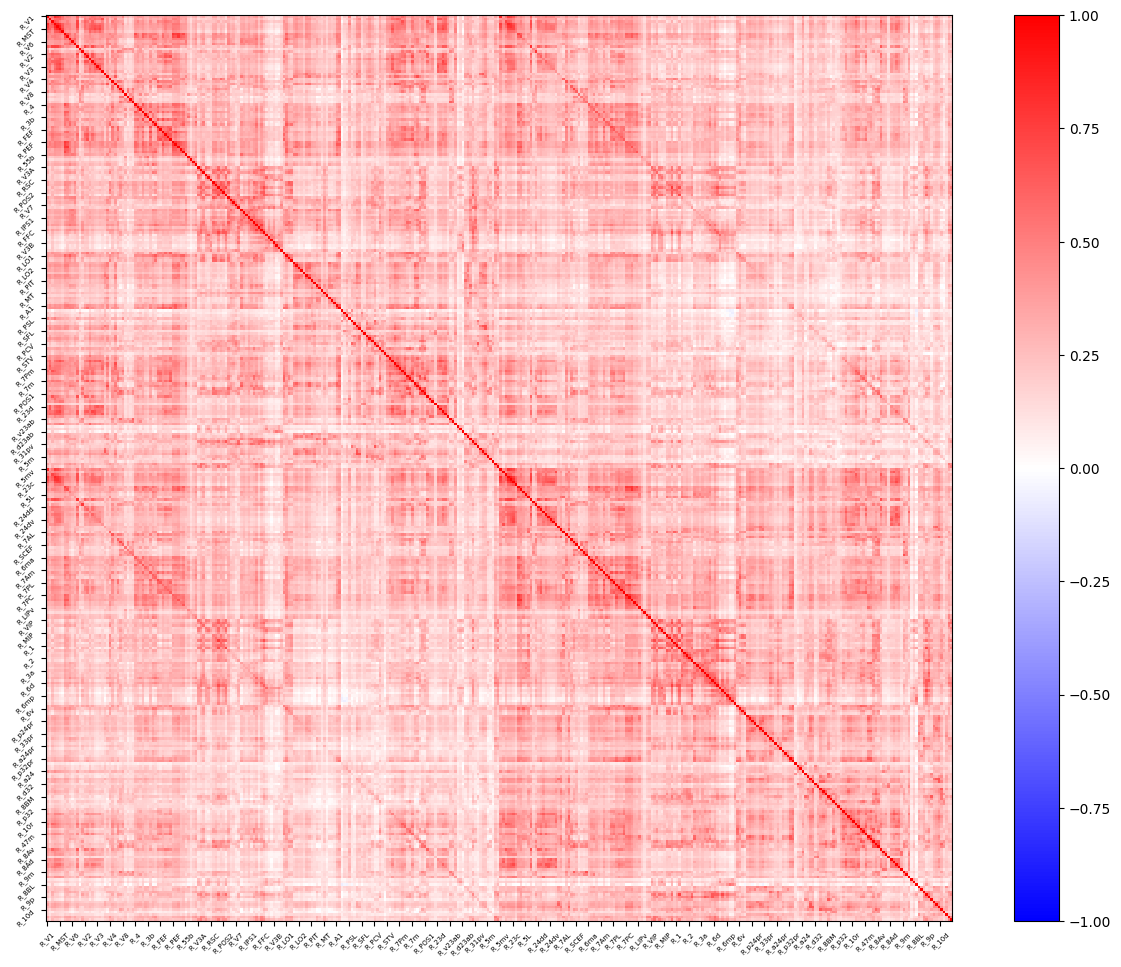

In [ ]:
#Generating a correlation matrix showing "functional connectivity for each subject"
fc = np.zeros((N_SUBJECTS, N_PARCELS, N_PARCELS))
for sub, ts in enumerate(timeseries_rest):
  fc[sub] = np.corrcoef(ts)

group_fc = fc.mean(axis=0)

#MOVE this to the top with other imports
from matplotlib import figure


ax = plt.figure(figsize=(16, 12), dpi=100)

#this grabs the axis so you can add labels
ax = plt.gca()

ax.set_xticks(np.arange(len(regions[0]), step = 5))
ax.set_yticks(np.arange(len(regions[0]), step = 5))
ax.set_xticklabels(regions[0], fontsize = 5, rotation = 45)
ax.set_yticklabels(regions[0], fontsize = 5, rotation = 45)


plt.imshow(group_fc, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
plt.colorbar()
plt.show()







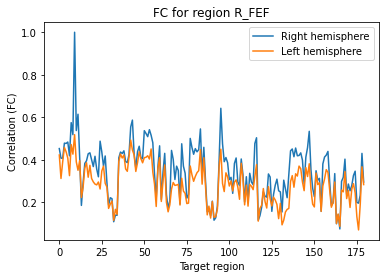

In [ ]:
#this segment plots the profile of functional connectivity between a particular "seed" parcel and the other parcels in the dataset (separated by hemispheres)
seed_roi = "R_FEF"  # name of seed parcel
ind = region_info["name"].index(seed_roi)

hemi_fc = np.split(group_fc, 2)

# Plot the FC profile across the right and left hemisphere target regions
for i, hemi_fc in enumerate(hemi_fc):
  plt.plot(hemi_fc[:, ind], label=f"{HEMIS[i]} hemisphere")
plt.title(f"FC for region {seed_roi}")
plt.xlabel("Target region")
plt.ylabel("Correlation (FC)")
plt.legend()
plt.show()

In [ ]:
# This produces and plots a connectome by creating an edge threshold for the correlation matrix
group_som = group_fc.copy()
group_fp = group_fc.copy()
group_som[regions[1] != "Somatomotor"] = 0
group_som[:,regions[1] != "Somatomotor"] = 0

group_fp[regions[1] != "Frontopariet"]= 0
group_fp[:,regions[1] != "Frontopariet"] = 0

plotting.view_connectome(group_som, atlas["coords"], edge_threshold="75%")


In [ ]:
plotting.view_connectome(group_fp, atlas["coords"], edge_threshold="75%")

In [ ]:
# Methods to get region names for a particular brain network and then split them by left and right hemisphere

def get_region_names(network):
  region_names = regions[0][regions[1] == network ]
  return region_names

def split_network_by_hemisphere(region_names):
  right_region_names = []
  left_region_names = []
  for roi in region_names:
    x = roi.split('_')
    if x[0] == 'R':
      right_region_names.append(roi)
    else:
      left_region_names.append(roi)
  return left_region_names, right_region_names

#roi = get_region_names('Frontopariet')

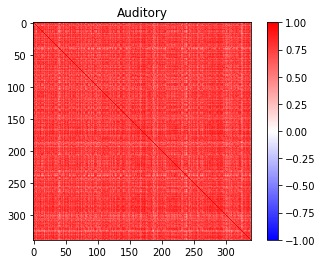

0.3667591721917119


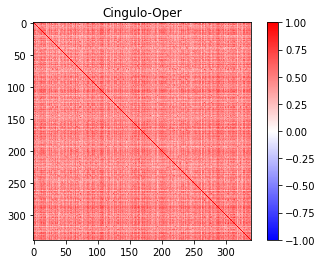

0.23109362194469496


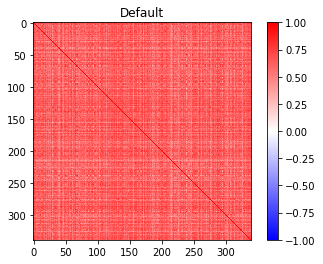

0.30873526904255316


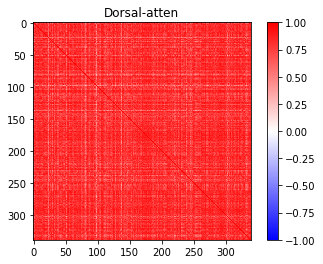

0.3947880106358371


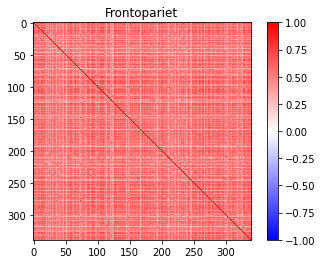

0.2558652352050908


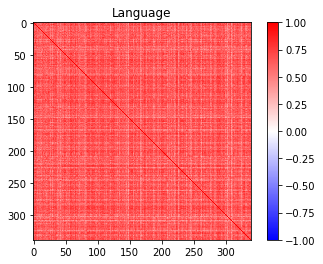

0.315506386229218


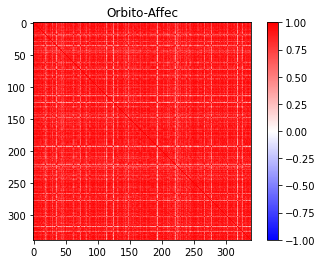

0.4224292104889902


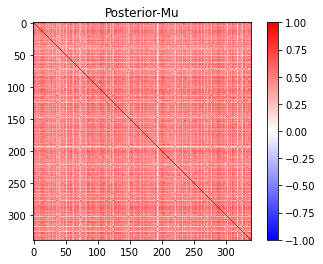

0.23042259992736497


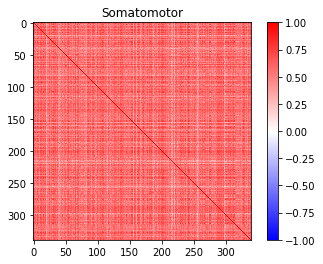

0.2809204325782605


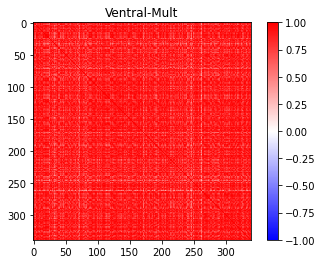

0.42989324044916605


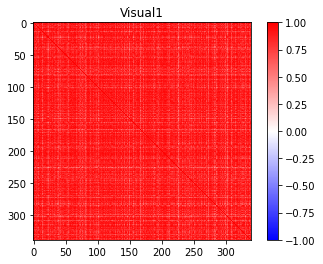

0.4272268287274676


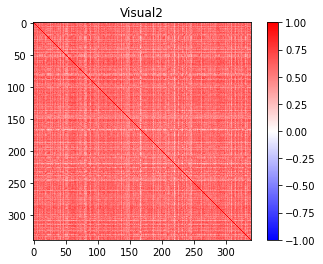

0.2735009911761834


In [ ]:
# Computing correlation matrix of functional connectivity for each subject

def compute_fc_by_subject(network):
  n_regions = len(get_region_names(network))
  fc = np.zeros((N_SUBJECTS, n_regions, n_regions))
  for sub, ts in enumerate(timeseries_rest):
    ts = ts[regions[1] == network]
    fc[sub] = np.corrcoef(ts)
  return fc


def compute_and_plot_similarity_by_subject(fcs, network):
  #Reshape flattens the matrix so that corrcoef can accept it as a param
  pairwise_correlations = np.corrcoef(fcs.reshape(N_SUBJECTS, -1))
  plt.imshow(pairwise_correlations, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
  plt.colorbar()
  plt.title(network)
  plt.show()
  return pairwise_correlations

all_networks = np.unique(regions[1])

for n in all_networks:
  network = n
  fcs = compute_fc_by_subject(network)
  pc = compute_and_plot_similarity_by_subject(fcs, network)
  print(np.mean(np.triu((pc))))








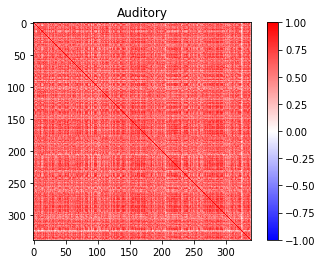

0.29725510949880213


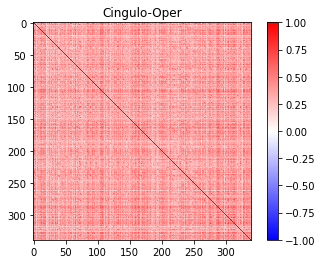

0.18254728028842346


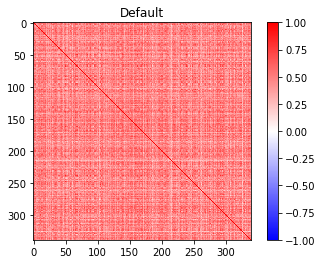

0.2405556463560221


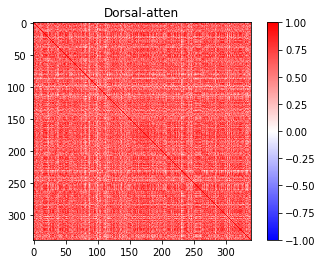

0.30886450208638844


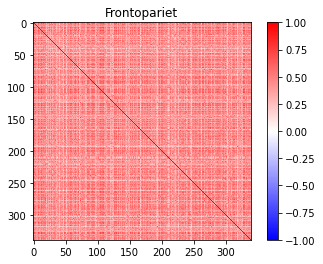

0.21729460550847482


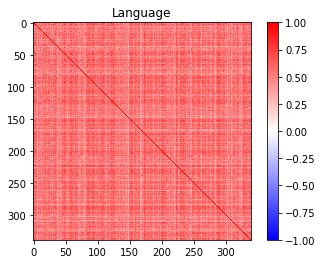

0.26866074931768325


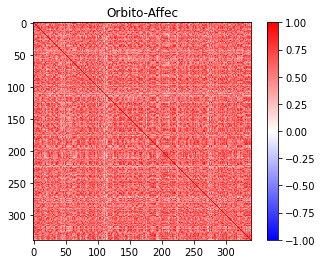

0.2848903830441295


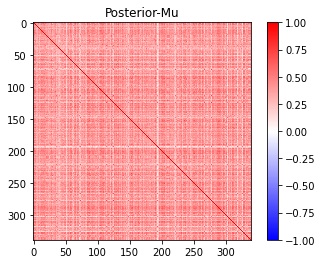

0.1960325892655847


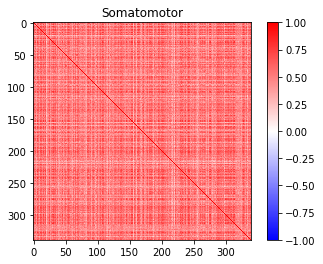

0.25590499751379286


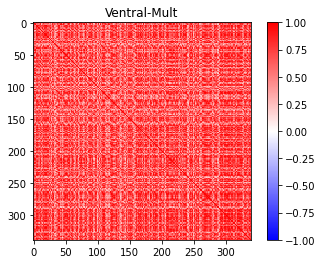

0.3325234106885067


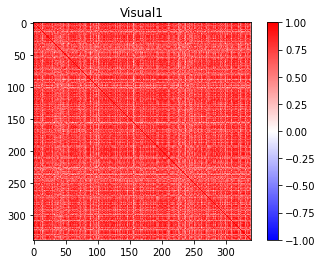

0.34906833640558155


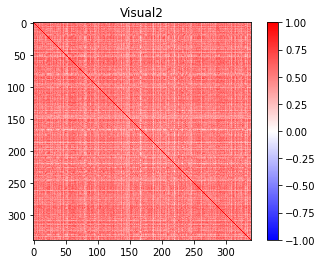

0.24675357312859378


In [ ]:
def compute_and_plot_similarity_by_subject_spearman(fcs, network):
  #Reshape flattens the matrix so that corrcoef can accept it as a param
  rho, pval = stats.spearmanr(fcs.reshape(N_SUBJECTS, -1), axis = 1)
  plt.imshow(rho, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
  plt.colorbar()
  plt.title(network)
  plt.show()
  return rho

#Spearman correlation: Spearman correlation evaluates the monotonic relationship. 
#The Spearman correlation coefficient is based on the ranked values for each variable rather than the raw data.
for n in all_networks:
  network = n
  fcs = compute_fc_by_subject(network)
  pc = compute_and_plot_similarity_by_subject_spearman(fcs, network)
  print(np.mean(np.triu(pc)))

In [ ]:
def extract_x_and_y(network, sub, roi):
  rois = get_region_names(network)
  data = timeseries_rest[sub][regions[1] == network]
  x = data[np.where(rois != roi)].T
  y = data[np.where(rois == roi)].T
  return x, y

def run_linear_regression(network, sub, roi): 
  x, y = extract_x_and_y(network, sub, roi)
  model = Lasso(alpha = 0.2).fit(x, y)
  return model

def compute_mse(model, x, y):
  #Testing the model using mean-squared error
  mse = sklearn.metrics.mean_squared_error(model.predict(x), y)
  return mse

def make_results_matrix(model, network):
  mse_vec = np.zeros(len(subjects))
  for sub2 in subjects:
    x, y = extract_x_and_y(network, sub2, roi)
    mse = compute_mse(model, x, y)
    mse_vec[sub2] = mse
  return mse_vec

def make_correlation_matrix(model, network):
  corr_vec = np.zeros(len(subjects))
  for sub2 in subjects:
    x, y = extract_x_and_y(network, sub2, roi)
    corr = np.corrcoef(model.predict(x), np.reshape(y, 4800))
    corr_vec[sub2] = corr[1][0]
  return corr_vec

#Run the whole data analysis 
#network = 'Posterior-Mu'
#rois = get_region_names(network)
#subjects = range(N_SUBJECTS)
#subjects = subjects[0:10]
#results_matrix = np.zeros((len(subjects),len(rois),len(subjects)))
#corr_matrix = np.zeros((len(subjects),len(rois),len(subjects)))
#for sub in subjects:
  #for i, roi in enumerate(rois): 
    #model = run_linear_regression(network, sub, roi) 
    #results_matrix[sub, i, :] = make_results_matrix(model, network)
    #corr_matrix[sub, i, :] = make_correlation_matrix(model, network)


#plot_results(results_matrix)



In [ ]:
#Run the whole data analysis for a different network: SOMATOMOTOR
network = 'Somatomotor'
rois = get_region_names(network)
subjects = range(N_SUBJECTS)
results_matrix_som = np.zeros((len(subjects),len(rois),len(subjects)))
corr_matrix_som = np.zeros((len(subjects),len(rois),len(subjects)))
for sub in subjects:
  for i, roi in enumerate(rois): 
    model = run_linear_regression(network, sub, roi) 
    results_matrix_som[sub, i, :] = make_results_matrix(model, network)
    corr_matrix_som[sub, i, :] = make_correlation_matrix(model, network)

#To save numpy array we need to reshape it or save a seperate CVS file for each participant. 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5532.433992994716, tolerance: 4704.125283154168
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59137.14335229993, tolerance: 7854.712243155833
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27777.916090908227, tolerance: 5942.471596159823
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9571.570716

In [ ]:
#Run the whole data analysis for a different network: FRONTOPARIET
network = 'Frontopariet'
rois = get_region_names(network)
subjects = range(N_SUBJECTS)
results_matrix_fp = np.zeros((len(subjects),len(rois),len(subjects)))
corr_matrix_fp = np.zeros((len(subjects),len(rois),len(subjects)))
for sub in subjects:
  for i, roi in enumerate(rois): 
    model = run_linear_regression(network, sub, roi) 
    results_matrix_fp[sub, i, :] = make_results_matrix(model, network)
    corr_matrix_fp[sub, i, :] = make_correlation_matrix(model, network)

In [ ]:

corr_matrix_avg = np.mean(corr_matrix, axis = 1)
plt.imshow(corr_matrix_avg, interpolation="none", cmap="bwr", vmin=0, vmax=1)
plt.colorbar()
plt.title(network)
plt.show()

results_matrix_avg = np.mean(results_matrix, axis = 1)
plt.imshow(results_matrix_avg, interpolation="none", cmap="bwr")
plt.colorbar()
plt.title(network)
plt.show()


NameError: ignored

(array([1., 0., 0., 0., 3., 2., 1., 0., 2., 1.]),
 array([0.63347385, 0.66183337, 0.69019289, 0.71855241, 0.74691193,
        0.77527146, 0.80363098, 0.8319905 , 0.86035002, 0.88870954,
        0.91706906]),
 <a list of 10 Patch objects>)

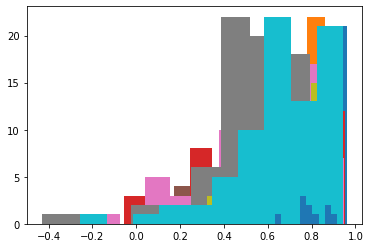

In [ ]:
#Visualizing our results by plotting the distribution

sub = 0
for p in subjects:
  plt.hist(corr_matrix[0, :, p])







/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


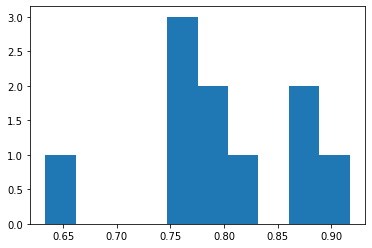

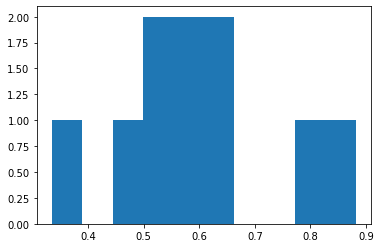

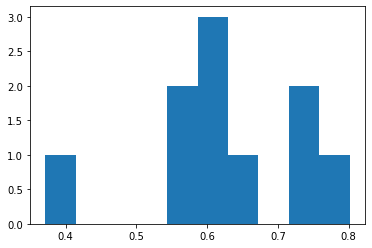

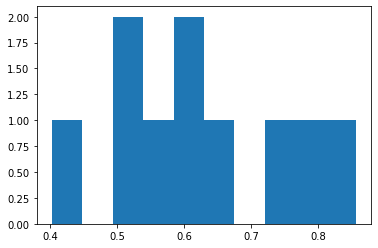

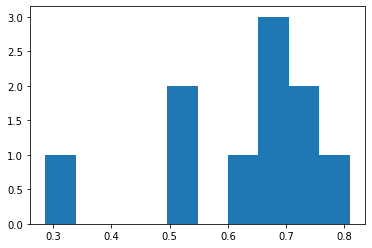

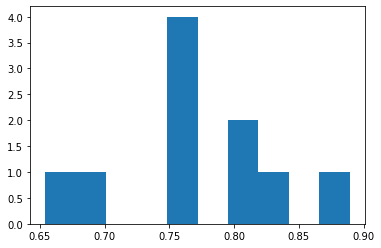

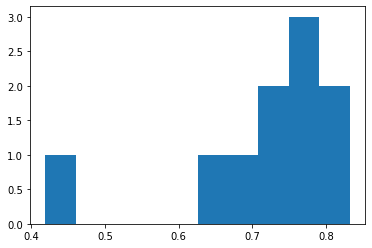

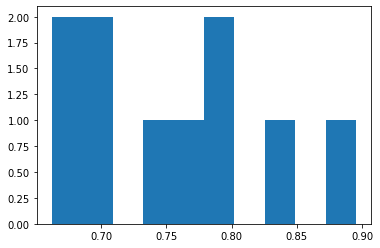

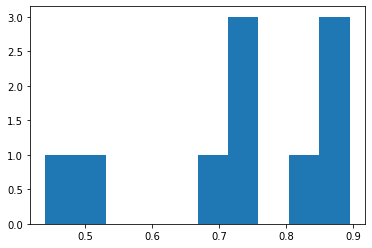

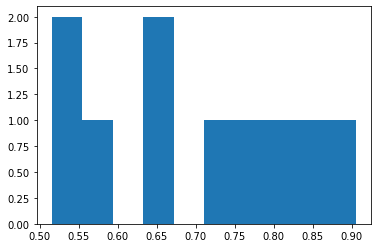

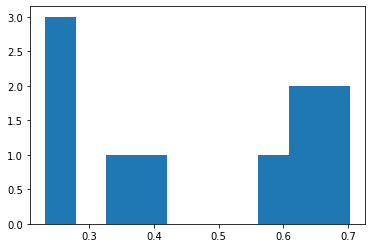

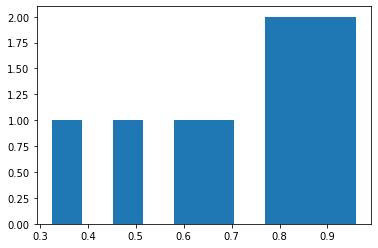

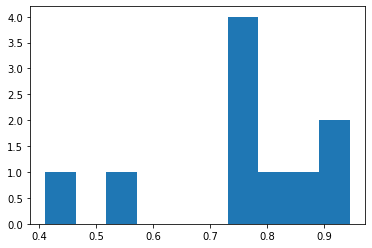

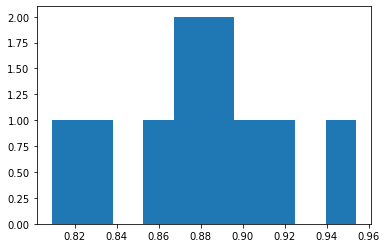

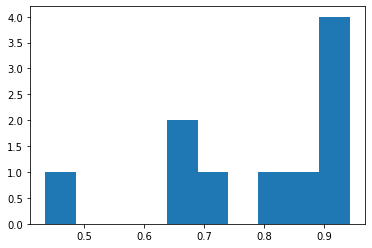

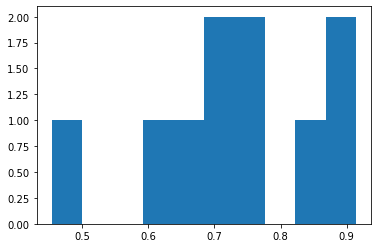

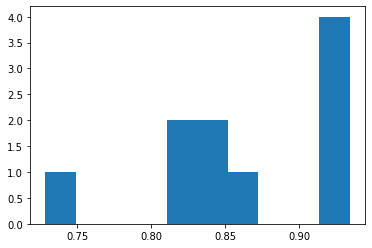

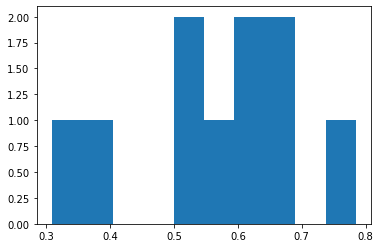

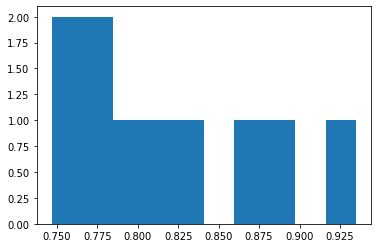

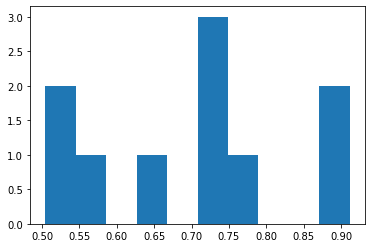

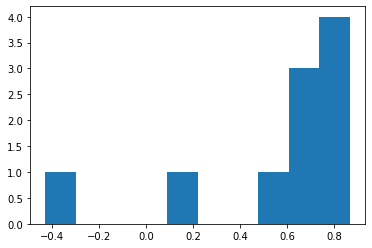

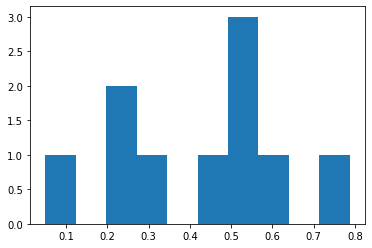

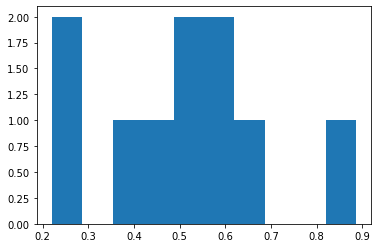

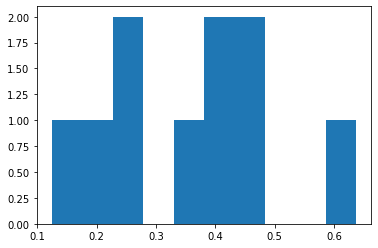

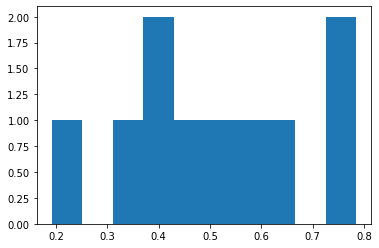

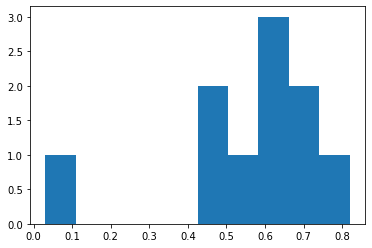

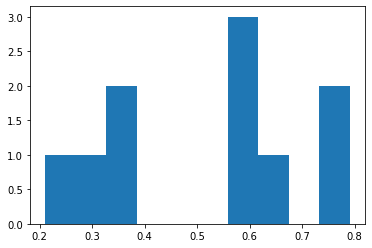

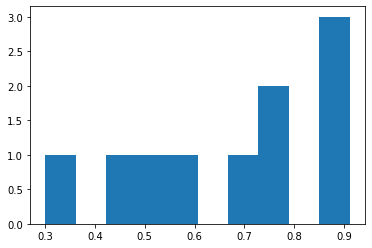

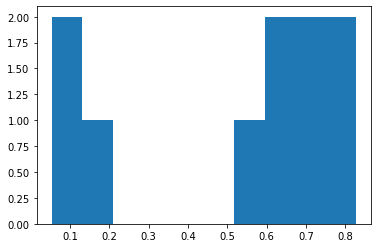

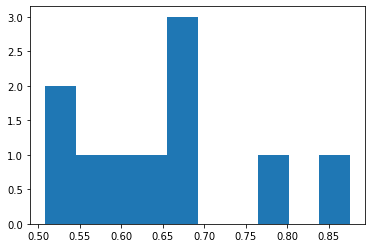

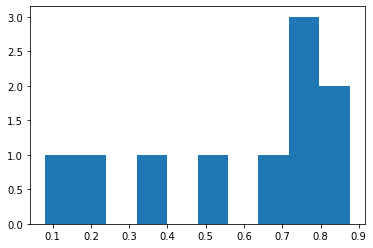

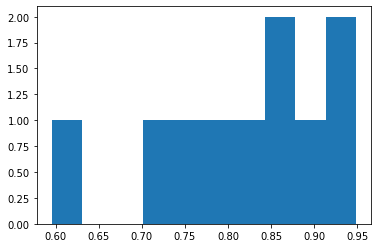

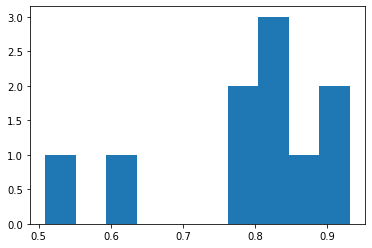

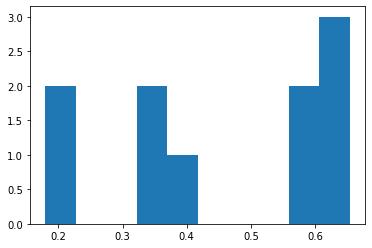

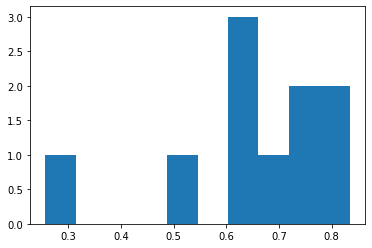

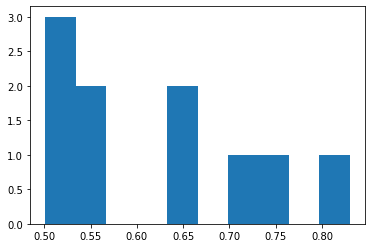

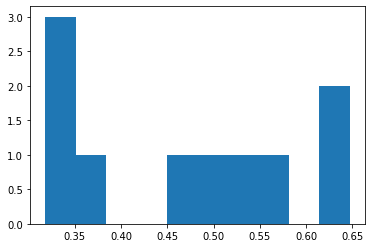

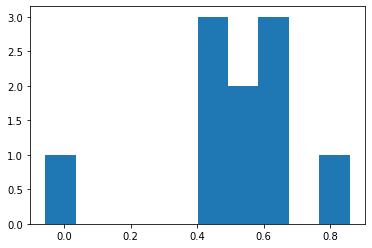

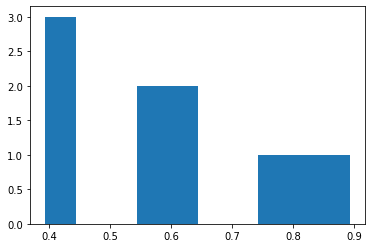

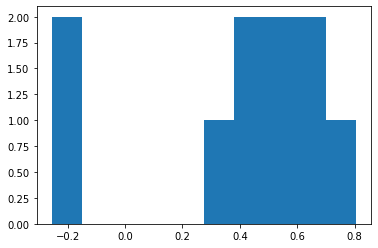

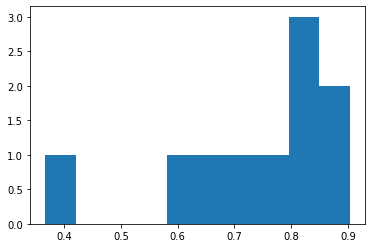

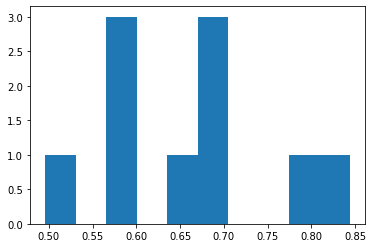

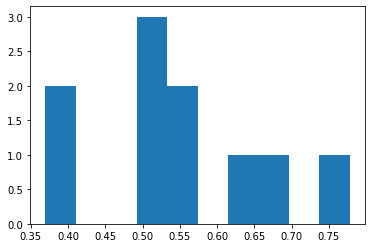

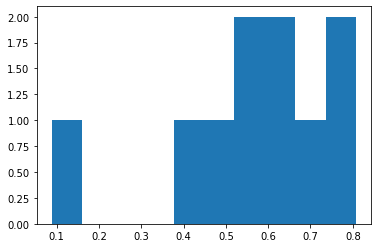

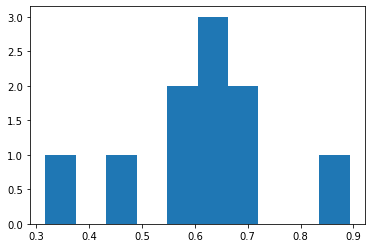

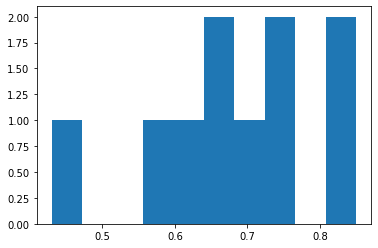

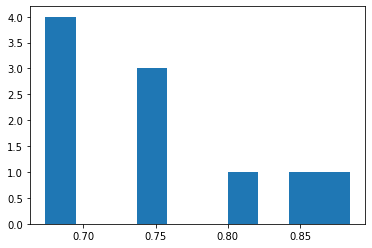

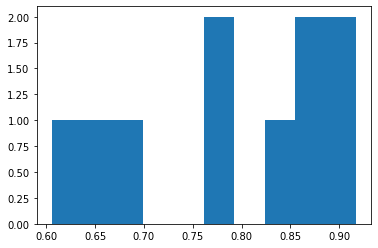

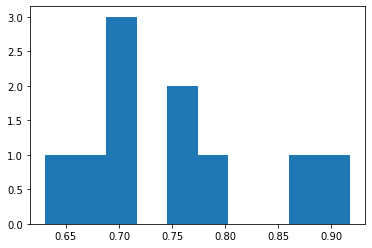

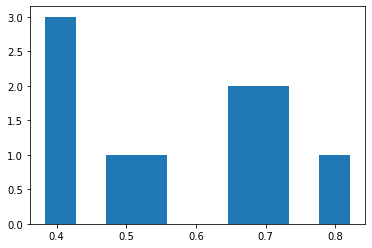

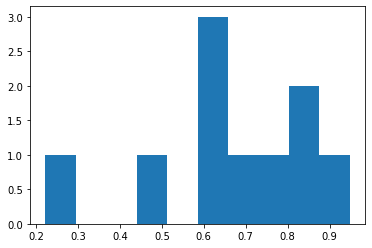

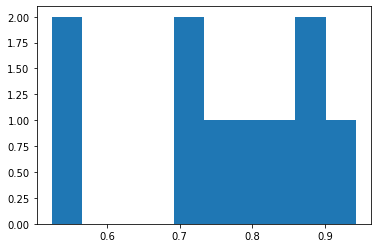

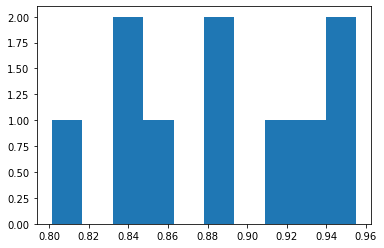

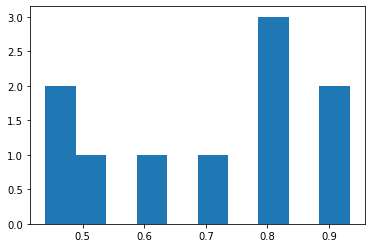

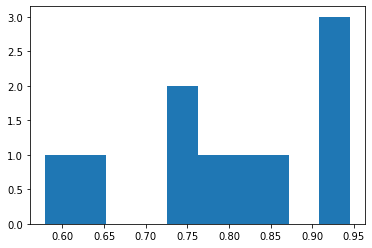

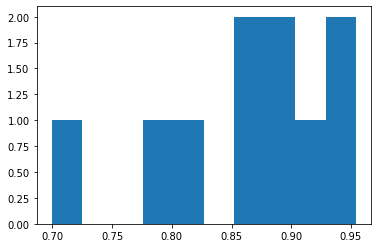

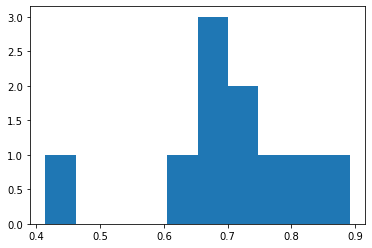

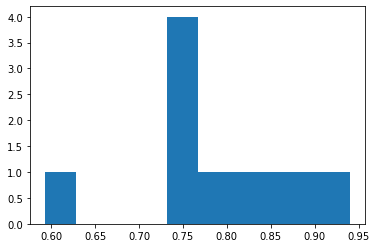

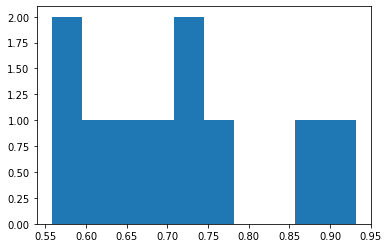

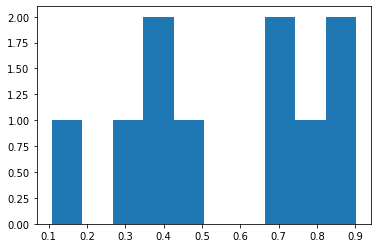

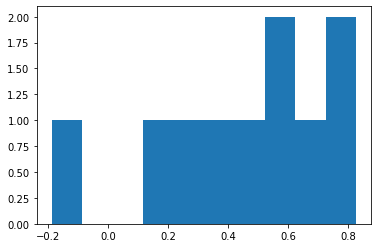

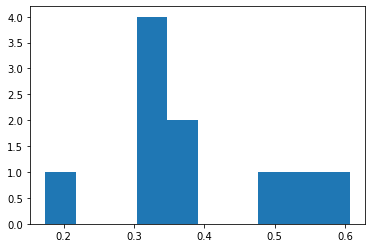

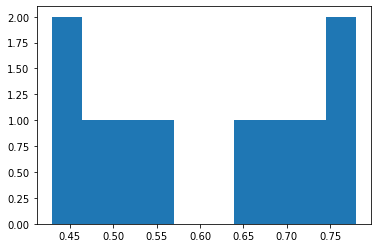

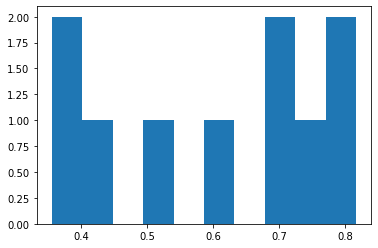

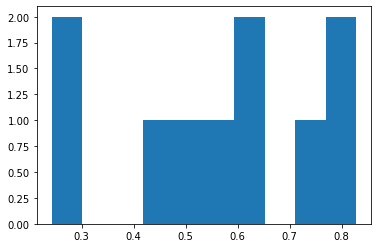

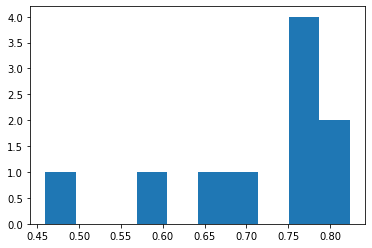

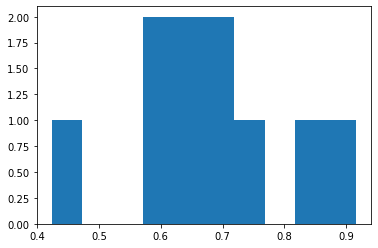

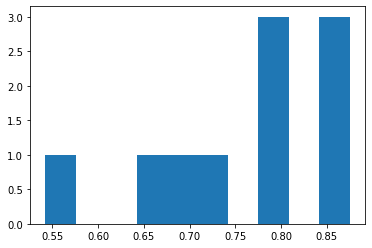

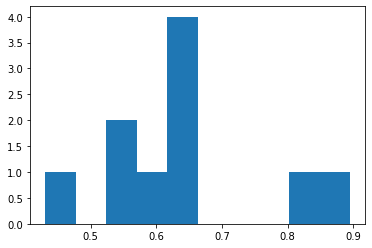

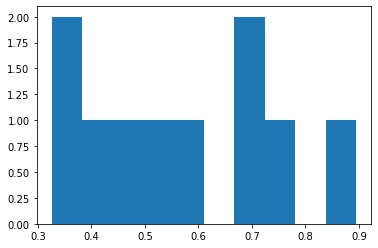

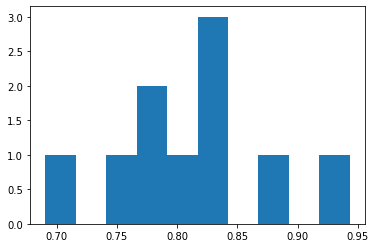

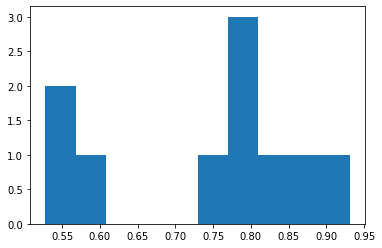

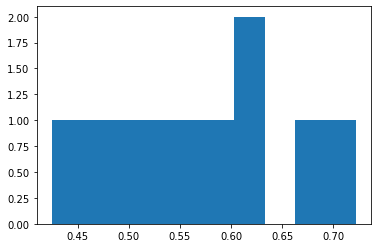

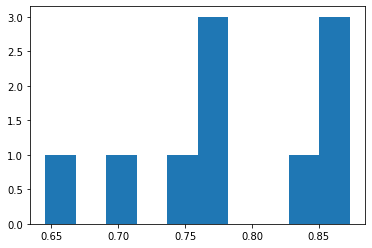

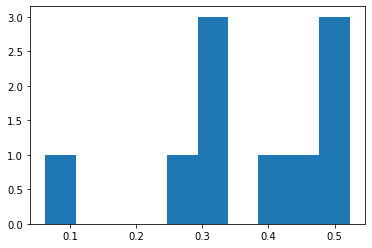

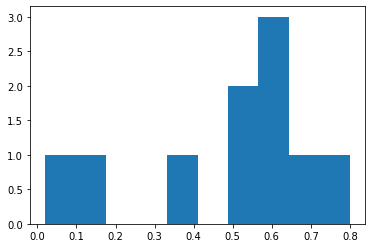

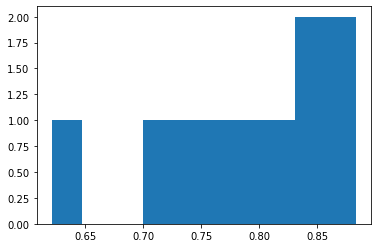

In [ ]:

for i, roi in enumerate(rois):  
  plt.figure()
  plt.hist(corr_matrix[0, i, :])

(50, 50)
(50, 2)
[0.22873643 0.13356903]


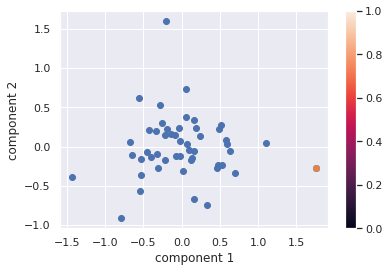

In [ ]:
#Applying PCA to our analysis to search for clusters

#pca = sklearn.decomposition.PCA(corr_matrix[0].T)
print(corr_matrix[0].T.shape)

pca = sklearn.decomposition.PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(corr_matrix[0].T)
print(projected.shape)


plt.scatter(projected[:, 0], projected[:, 1])
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

print(pca.explained_variance_ratio_)

plt.scatter(*projected[0])


In [ ]:
import seaborn as sns; sns.set_theme(color_codes=True)


h = sns.clustermap(corr_matrix[0], cmap= 'mako')
#plt.setp(h.ax_heatmap.get_yticklabels(), rotation=0)  # For y axis
#plt.setp(h.ax_heatmap.get_xticklabels(), rotation=90) # For x axis




In [ ]:
#Saving the correlation matrices
np.save("corr_matrix_som", corr_matrix_som)
np.save("corr_matrix_fp", corr_matrix_fp)




[0.22563383 0.13050371]


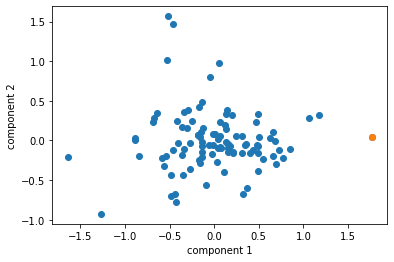

In [ ]:
#Applying PCA to our analysis to search for clusters

#pca = sklearn.decomposition.PCA(corr_matrix[0].T)

def pca_corr_matrix(corr_matrix):
  pca = sklearn.decomposition.PCA(2)  # project from 64 to 2 dimensions
  projected = pca.fit_transform(corr_matrix[0].T)
  plt.scatter(projected[:, 0], projected[:, 1])
  plt.xlabel('component 1')
  plt.ylabel('component 2')
  print(pca.explained_variance_ratio_)
  plt.scatter(*projected[0])

pca_corr_matrix(corr_matrix_fp)




[0.43421366 0.08807704]


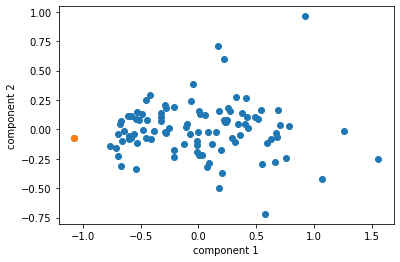

In [ ]:
pca_corr_matrix(corr_matrix_som)

In [ ]:
network = 'Posterior-Mu'
rois = get_region_names(network)
subjects = range(N_SUBJECTS)
results_matrix = np.zeros((len(subjects),len(rois),len(subjects)))
corr_matrix = np.zeros((len(subjects),len(rois),len(subjects)))
sub = 0
for i, roi in enumerate(rois): 
  model = run_linear_regression(network, sub, roi) 
  results_matrix[sub, i, :] = make_results_matrix(model, network)
  corr_matrix[sub, i, :] = make_correlation_matrix(model, network)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8986.677255548537, tolerance: 6607.80628367581
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19540.095758080482, tolerance: 10509.0216611825
  positive)


[0.18339368 0.12354859]


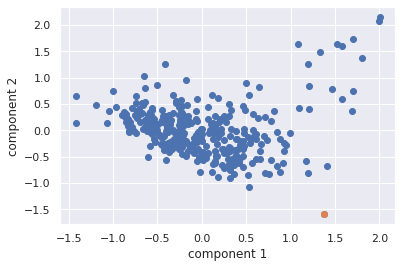

In [ ]:
pca_corr_matrix(corr_matrix)

In [ ]:
np.save("regions", regions)